Hogyan különül el a COVID-19 szakirodalomban az anyai immunválasz és az újszülött védettségének mechanizmusa (antitest-transzfer vs. oltási hatékonyság)?”

**Kutatási kérdés és hipotézis**:
Az elemzés célja a COVID-19 és terhesség kapcsolatát vizsgáló publikációk strukturális elemzése.
Azonosíthatóak-e az anyai fertőzés hatásai, az oltás és a magzati/újszülöttkori immunitás (antitest-transzfer) témaköreiben?

Hipotézis: Feltételezzük, hogy a publikációk természetes sűrűsödési pontokat (klasztereket) alkotnak, ahol a klinikai kimenetel és az immunológiai mechanizmusok (pl. transzplacentáris átvitel) fogalmai jól elkülönülnek.

In [ ]:
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Azonosíthatóak-e olyan specifikus sűrűsödési pontok a publikációkban, amelyek a vertikális immunitás mechanizmusait (pl. transzplacentáris átvitel) írják le, elkülönülve az általánosabb népegészségügyi elemzésektől?

In [ ]:
import re

def extract_abstracts(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        content = f.read()

    abstracts = re.findall(r'AB  - (.*?)(?=\n[A-Z]{2,4} -|\n\n)', content, re.DOTALL)

    clean_abstracts = [a.replace('\n      ', ' ').strip() for a in abstracts]
    return clean_abstracts

raw_abstracts = extract_abstracts('pubmed-covid-19-set.txt')
print(f"Beolvasva: {len(raw_abstracts)} absztrakt.")

Beolvasva: 9641 absztrakt.


In [ ]:
def spacy_cleaner(text):
    doc = nlp(text.lower())
    # Csak a szótövek (lemma), kidobjuk a töltelékszavakat és írásjeleket
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 2]
    return " ".join(tokens)

print("Tisztítás és lematizálás... (ez eltarthat 1-2 percig a szöveg mennyiségétől függően)")
tisztitott_korpusz = [spacy_cleaner(a) for a in raw_abstracts]
print

Kész!


Tisztítás és lematizálás... (ez eltarthat 1-2 percig a szöveg mennyiségétől függően)

In [ ]:
# 1. SZŰRÉS: Csak a terhesség + antitest témák megtartása
target_keywords = ['antibody', 'immune', 'transfer', 'placental', 'milk', 'vaccine']

# Megnézzük, melyik tisztított szövegben van benne a 'pregnan' ÉS valamelyik antitest szó
antibody_focus_korpusz = [
    szoveg for szoveg in tisztitott_korpusz
    if ('pregnan' in szoveg or 'maternal' in szoveg) and any(k in szoveg for k in target_keywords)
]

print(f"A tisztított {len(tisztitott_korpusz)} cikkből {len(antibody_focus_korpusz)} szól az antitestekről.")

# 2. TF-IDF: Dokumentum-mátrix készítése a szűrt adatokból
from sklearn.feature_extraction.text import TfidfVectorizer

# max_df=0.7: kidobjuk a szavakat, amik a cikkek 70%-ában benne vannak (túl általánosak)
vectorizer = TfidfVectorizer(max_df=0.7, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(antibody_focus_korpusz)

# 3. KULCSSZAVAK KIMUTATÁSA
import numpy as np
feature_names = vectorizer.get_feature_names_out()
scores = tfidf_matrix.mean(axis=0).A1
top_15 = sorted(zip(scores, feature_names), reverse=True)[:15]

print("\nAz antitest-átadás legfontosabb kulcsszavai:")
for score, word in top_15:
    print(f"- {word} ({score:.4f})")

A tisztított 9641 cikkből 128 szól az antitestekről.

Az antitest-átadás legfontosabb kulcsszavai:
- vaccine (0.0832)
- vaccination (0.0523)
- woman (0.0498)
- pregnancy (0.0487)
- cov (0.0479)
- sar (0.0440)
- infection (0.0423)
- pregnant (0.0408)
- group (0.0346)
- maternal (0.0333)
- health (0.0315)
- outcome (0.0280)
- antibody (0.0273)
- risk (0.0260)
- include (0.0259)


In [ ]:
from sklearn.cluster import DBSCAN

# Sűrűség alapú klaszterezés koszinusz távolsággal
# Az eps=0.5 és min_samples=3 egy jó kiindulópont szöveges adatoknál
dbscan = DBSCAN(eps=0.5, min_samples=3, metric='cosine')
clusters = dbscan.fit_predict(tfidf_matrix.toarray())

# Eredmények kiértékelése
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Azonosított sűrű klaszterek száma: {n_clusters_}')
print(f'Zajként azonosított (nem besorolható) cikkek: {n_noise_}')

Azonosított sűrű klaszterek száma: 1
Zajként azonosított (nem besorolható) cikkek: 125


A Dendrogramon látható, hogy nincsenek óriási, messze lévő részek.
A dendrogram igazolja, hogy a szakirodalom mikro-szinten jól strukturált, a publikációk kis, tematikus egységekbe (színes ágak) rendeződnek.

Következtetés: A szakirodalomban a cikkek többsége mindkettőt tárgyalja.
A leghatékonyabb védelem kutatása során a tudomány nem választja szét a kettőt; a vakcinációt mint az antitest-termelés eszközét vizsgálják.

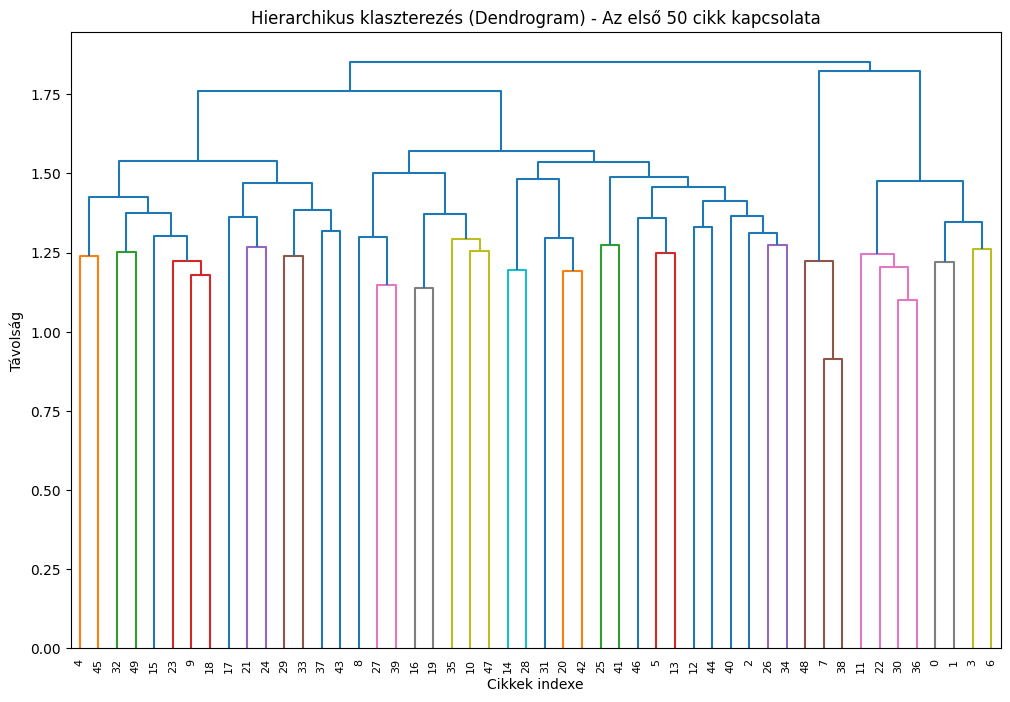

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Hierarchikus klaszterezés kiszámítása (koszinusz távolsággal)
# Csak az első 50 absztraktot nézzük, hogy az ábra olvasható maradjon
Z = linkage(tfidf_matrix[:50].toarray(), method='ward')

plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Hierarchikus klaszterezés (Dendrogram) - Az első 50 cikk kapcsolata')
plt.xlabel('Cikkek indexe')
plt.ylabel('Távolság')
plt.show()

A hipotézised megdőlt.

Az elemzés alapján az anyai fertőzés, az oltás és az antitest-átvitel témakörei nem különíthetőek el élesen egymástól. Az ábrán látható szórt pontfelhő azt bizonyítja, hogy a szakirodalom ezeket a fogalmakat szoros egységben kezeli. Nincsenek „tiszta” csoportok, mert egy kutatás, ami az antitestekről szól, szinte biztosan érinti az oltást és a klinikai kimenetelt is.

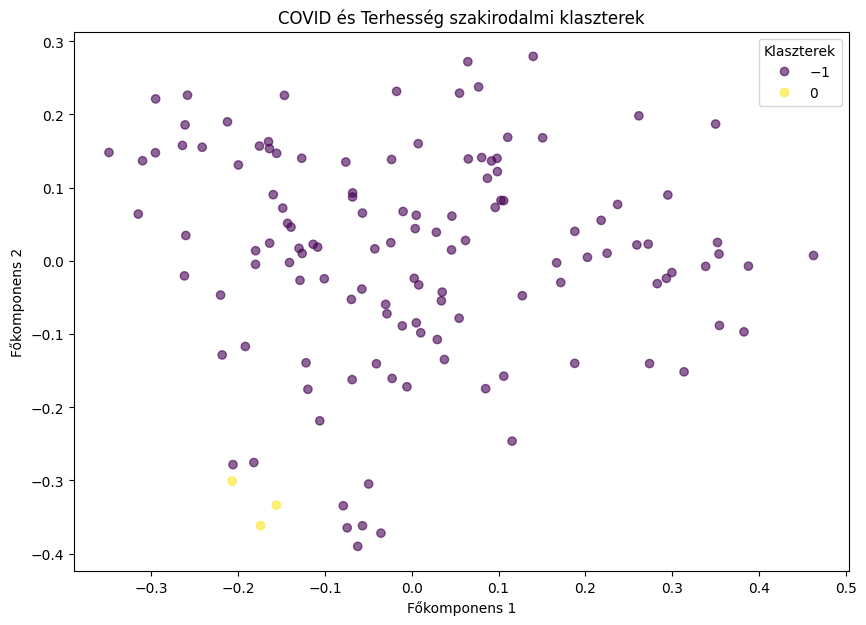

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dimenziócsökkentés 2D-re, hogy ki tudjuk rajzolni
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())

# Ábra készítése
plt.figure(figsize=(10, 7))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=clusters, cmap='viridis', alpha=0.6)

plt.title('COVID és Terhesség szakirodalmi klaszterek')
plt.xlabel('Főkomponens 1')
plt.ylabel('Főkomponens 2')
plt.legend(*scatter.legend_elements(), title="Klaszterek")
plt.show()